# HYPERPARAMETER TUNING

### Hyperparameter Tuning: Optimization of the Regularization Parameter \(C\)

After selecting **Support Vector Machine (SVM)** as the most suitable model, the next step involves optimizing its **regularization parameter \(C\)** to achieve the best performance. The tuning process is conducted through a **validation curve**, using a **5-fold cross-validation framework**, repeated **20 times**.

To ensure a robust assessment, the model’s performance is evaluated on:
- The **oversampled training set**, where SMOTE is applied to balance class distribution.
- The **test set**, which is scaled and transformed using the same preprocessing pipeline derived from the training set.

Since the dataset is **imbalanced**, the chosen evaluation metric is **AUC (Area Under the Curve)**, as it provides a comprehensive measure of the classifier’s ability to distinguish between classes, regardless of class distribution. Through this process, the analysis of performance metrics across different values of \(C\) leads to the selection of **\(C = 1\)**, as it optimally balances classification accuracy and generalization, ensuring stable and efficient model behavior.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score

In [2]:
data = pd.read_csv('../data/raw/Pistachio_16_Features_Dataset.csv')

In [3]:
del data['id']

data.replace({'Kirmizi_Pistachio': 0, 'Siit_Pistachio' : 1 }, inplace=True)

X = data.iloc[:, 0:16]
columns = X.columns.to_list()

y = data[["Class"]]

In [4]:
C_values = [0.001, 0.01, 0.1, 1, 10, 100]

auc_train_results = {C: [] for C in C_values}
auc_valid_results = {C: [] for C in C_values}

for C in C_values:
    
    train_auc_scores_repeated = []  
    valid_auc_scores = []

    for i in range(1, 21):  
        
        kf = StratifiedKFold(n_splits=5, random_state=i, shuffle=True)

        train_auc_scores = []
        y_pred_valid = pd.DataFrame(index=X.index, columns=['Prediction']) 

        for train_index, test_index in kf.split(X, y):
            
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index].values.ravel(), y.iloc[test_index].values.ravel()

            # Oversampling using SMOTE
            sm = SMOTE(random_state=i)
            X_train_oversampled, y_train_oversampled = sm.fit_resample(X_train, y_train)

            # Standardization
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train_oversampled)
            X_test_scaled = scaler.transform(X_test)

            # PCA transformation
            pca = PCA(n_components=5)
            X_train_pca = pca.fit_transform(X_train_scaled)
            X_test_pca = pca.transform(X_test_scaled)

            # Model training
            svm = SVC(C=C, kernel='rbf', gamma='scale')
            svm.fit(X_train_pca, y_train_oversampled)

            # Model prediction
            y_pred_valid.loc[test_index, 'Prediction'] = svm.predict(X_test_pca)

            # Model prediction for the training set
            y_pred_train = svm.predict(X_train_pca)  
            train_auc_scores.append(roc_auc_score(y_train_oversampled.astype(int), y_pred_train.astype(int)))

        
        train_auc_scores_repeated.append(np.mean(train_auc_scores))
        valid_auc_scores.append(roc_auc_score(y['Class'].astype(int), y_pred_valid['Prediction'].astype(int)))

    
    auc_train_results[C] = train_auc_scores_repeated
    auc_valid_results[C] = valid_auc_scores

auc_train_means = {C: np.mean(auc_train_results[C]) for C in C_values}
auc_train_stds = {C: np.std(auc_train_results[C]) for C in C_values}
auc_valid_means = {C: np.mean(auc_valid_results[C]) for C in C_values}
auc_valid_stds = {C: np.std(auc_valid_results[C]) for C in C_values}

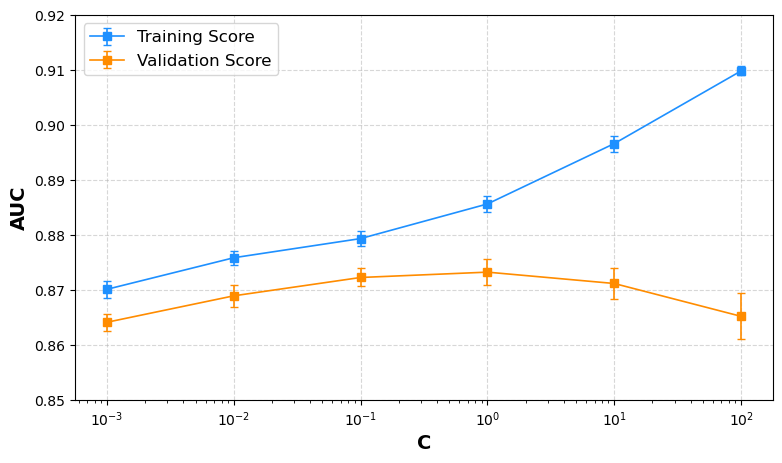

In [5]:
plt.figure(figsize=(9,5))

plt.errorbar(C_values, list(auc_train_means.values()), yerr=list(auc_train_stds.values()), fmt='s-', capsize=3, 
             label="Training Score", color='dodgerblue', markersize=6, linewidth=1.2)

plt.errorbar(C_values, list(auc_valid_means.values()), yerr=list(auc_valid_stds.values()), fmt='s-', capsize=3, 
             label="Validation Score", color='darkorange', markersize=6, linewidth=1.2)

plt.xscale("log")
plt.xlabel("C", fontsize=14, weight='bold')
plt.ylabel("AUC", fontsize=14, weight='bold')
plt.ylim(0.85,0.92)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(fontsize=12, loc="upper left")
plt.show()